In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
## Load in the merged SF EUI/SF Property Info Map Data
datafile = "merged_SF_EUI_SF_Info_Map_df.csv"
df=pd.read_csv(datafile)

# Delete year built >2017
df = df.loc[df['year_built_cl']<=2017,:].reset_index()


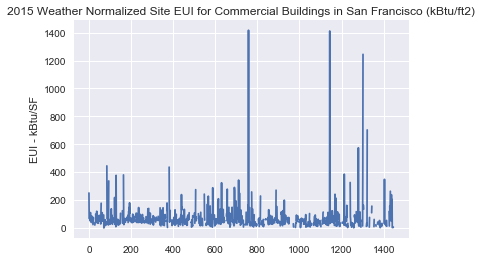

In [3]:
fig, ax = plt.subplots()
plt.plot(df['2015 Weather Normalized Site EUI (kBtu/ft2)'])
ax.set_title('2015 Weather Normalized Site EUI for Commercial Buildings in San Francisco (kBtu/ft2)')
ax.set_ylabel('EUI - kBtu/SF')

In [4]:
all_vals_y_data = df.dropna(subset = ['2015 Weather Normalized Site EUI (kBtu/ft2)']).copy().reset_index()
all_vals_y_data.dropna(thresh= (len(all_vals_y_data) - 200), axis=1, inplace = True)


In [5]:
all_vals_y_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 21 columns):
level_0                                        978 non-null int64
index                                          978 non-null int64
Unnamed: 0                                     978 non-null int64
Unnamed: 0.1                                   978 non-null int64
parcel_index                                   978 non-null object
Postal Code                                    978 non-null int64
Full_Address_clean                             978 non-null object
Building Name_clean                            978 non-null object
Energy Audit Status_clean                      977 non-null object
Benchmark 2015 Status_clean                    978 non-null object
Property Type - Self Selected_clean            978 non-null object
Datetime Energy Audit Due                      977 non-null object
Energy Audit Status_clean.1                    977 non-null object
2015 Weather Normalized Site 

In [6]:
all_vals_y_data.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Energy Audit Status_clean.1', 'level_0', 'index'], axis=1, inplace = True)

In [7]:
x_complete_all_vals_y_data = all_vals_y_data.dropna().copy()

In [8]:
def choose_building_type(n):
    building_type = 'Other'
    if n in ['Urgent Care/Clinic/Other Outpatient', 'Hospital (General Medical & Surgical)', 'Veterinary Office', 'Laboratory']:
        building_type = 'Healthcare or Laboratory'
    if n in ['Restaurant', 'Food Sales','Supermarket/Grocery Store', 'Food Service', 'Other - Restaurant/Bar']:
        building_type = 'Food Service'
    if n in ['Office', 'Financial Office', 'Medical Office', 'Bank Branch']:
        building_type = 'Office'
    if n in ['Worship Facility', 'Social/Meeting Hall', 'Other - Recreation', 'Senior Care Community', 'Other - Entertainment/Public Assembly', 'Museum']:   
        building_type = 'Community Facility'
    if n in ['Hotel']:
        building_type = 'Hospitality'
    if n in ['College/University', 'Other - Education','Adult Education', 'K-12 School', 'Pre-school/Daycare', 'Vocational School']:
        building_type = 'Education'
    if n in ['Mixed Use Property', 'Other - Mall','Enclosed Mall','Repair Services (Vehicle, Shoe, Locksmith, etc.)','Automobile Dealership','Other - Services', 'Retail Store', 'Personal Services (Health/Beauty, Dry Cleaning, etc.)', 'Strip Mall']:
        building_type = 'Mixed Use or Retail'
    if n in ['Parking']:
        building_type = 'Parking'
    if n in ['Manufacturing/Industrial Plant', '']:
        building_type = 'Manufacturing'
    if n in ['Fitness Center/Health Club/Gym']:
        building_type = 'Fitness'
    if n in ['Movie Theater', 'Performing Arts', 'Bar/Nightclub']:
        building_type = 'Entertainment Venue'
    if n in ['Self-Storage Facility', 'Non-Refrigerated Warehouse', 'Refrigerated Warehouse','Wholesale Club/Supercenter', 'Distribution Center']  :
        building_type = 'Warehouse Type'
    if n in ['Data Center']:
        building_type = 'Data Center'    
    return building_type    
    

In [9]:
all_vals_y_data['Grouped_Building_Type'] = all_vals_y_data['Property Type - Self Selected_clean'].apply(choose_building_type)

In [10]:
x_complete_all_vals_y_data = all_vals_y_data.dropna().copy()

In [11]:
x_complete_all_vals_y_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 0 to 972
Data columns (total 17 columns):
parcel_index                                   811 non-null object
Postal Code                                    811 non-null int64
Full_Address_clean                             811 non-null object
Building Name_clean                            811 non-null object
Energy Audit Status_clean                      811 non-null object
Benchmark 2015 Status_clean                    811 non-null object
Property Type - Self Selected_clean            811 non-null object
Datetime Energy Audit Due                      811 non-null object
2015 Weather Normalized Site EUI (kBtu/ft2)    811 non-null float64
address_cl                                     811 non-null object
land_value_cl                                  811 non-null float64
structure_value_cl                             811 non-null float64
year_built_cl                                  811 non-null float64
building_area_cl     

In [12]:
#need to make new datetime column for energy audit due date and convert year to int
x_complete_all_vals_y_data['Datetime Energy Audit Due'] = pd.to_datetime(x_complete_all_vals_y_data['Datetime Energy Audit Due'], format = "%Y-%m-%d")
x_complete_all_vals_y_data['Datetime Energy Audit Due'] = pd.to_numeric(x_complete_all_vals_y_data['Datetime Energy Audit Due'])
x_complete_all_vals_y_data['year_built_cl'] = x_complete_all_vals_y_data['year_built_cl'].apply(np.int64)

In [13]:
x_complete_all_vals_y_data = x_complete_all_vals_y_data[x_complete_all_vals_y_data['year_built_cl'] <= 2017]

In [14]:
x_complete_all_vals_y_data['2015 Weather Normalized Site EUI (kBtu/ft2)'].describe()

count     811.000000
mean       69.086313
std       100.507426
min        -0.600000
25%        31.650000
50%        50.900000
75%        74.600000
max      1417.600000
Name: 2015 Weather Normalized Site EUI (kBtu/ft2), dtype: float64

In [15]:
x_complete_all_vals_y_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 0 to 972
Data columns (total 17 columns):
parcel_index                                   811 non-null object
Postal Code                                    811 non-null int64
Full_Address_clean                             811 non-null object
Building Name_clean                            811 non-null object
Energy Audit Status_clean                      811 non-null object
Benchmark 2015 Status_clean                    811 non-null object
Property Type - Self Selected_clean            811 non-null object
Datetime Energy Audit Due                      811 non-null int64
2015 Weather Normalized Site EUI (kBtu/ft2)    811 non-null float64
address_cl                                     811 non-null object
land_value_cl                                  811 non-null float64
structure_value_cl                             811 non-null float64
year_built_cl                                  811 non-null int64
building_area_cl        

In [16]:
x_complete_all_vals_y_data = pd.get_dummies(x_complete_all_vals_y_data, columns=['Property Type - Self Selected_clean'])
x_complete_all_vals_y_data = pd.get_dummies(x_complete_all_vals_y_data, columns=['Energy Audit Status_clean'])
x_complete_all_vals_y_data = pd.get_dummies(x_complete_all_vals_y_data, columns=['Benchmark 2015 Status_clean'])
x_complete_all_vals_y_data = pd.get_dummies(x_complete_all_vals_y_data, columns = ['Grouped_Building_Type'])

In [17]:
#Separate our features from our target for linear regression model

X=x_complete_all_vals_y_data.drop(['2015 Weather Normalized Site EUI (kBtu/ft2)', 'parcel_index', 'Full_Address_clean', 'Building Name_clean', 'address_cl'], axis = 1)

y=x_complete_all_vals_y_data['2015 Weather Normalized Site EUI (kBtu/ft2)']

In [18]:
X.shape

(811, 78)

In [19]:
y.values.min()

-0.59999999999999998

In [20]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [21]:
#Try my own LassoCV code but with standardization

#produce kfolds of data w/ n_splits folds/splits
kf = KFold(n_splits=3, shuffle = True)

Prediction_error_list = [] 

alpha_lambda = np.arange(0.001,1,0.001)  

std = StandardScaler()

for val in alpha_lambda:    #loop over lambdas

    pred_err = 0.0    #initialize prediction error
    for train_index, test_index in kf.split(X):    #loop over the folds
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] #create training and test independent variable data without scaling
        std.fit(X_train) #apply fit only only training ddata
        X_tr, X_te = std.transform(X_train), std.transform(X_test)    #apply standard scaler and use to find best alpha
                         
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]    #create training and test dependent variable data

        model = Lasso(alpha = val, tol =0.3)    #create the model object with lambda equal to val in list
        results = model.fit(X_tr,y_train)    #fit the model
        pred_err += sum((model.predict(X_te) - y_test)**2)    #predict the test data, compute the error, and add to total
    
    Prediction_error_list.append(pred_err)    #append the prediction error
##    print('lambda value tested was:' , val, 'sum of prediction error was:' , pred_err)

print("We just ran this model using kfolds of:", kf.get_n_splits(X))

best_lambda = alpha_lambda[Prediction_error_list.index(min(Prediction_error_list))]

print("The best lambda value was:", best_lambda)    

#run the lasso with the best lambda value:
#Lambda = sum(((1.0/np.array(Prediction_error))/sum(1.0/np.array(Prediction_error)))*np.array(Lambda))    #compute lambda as the weighted average
model = Lasso(best_lambda)    #generate a model object
results = model.fit(X_tr,y_train) #fit the model

R_2_score = model.score(X_te, y_test)

test_set_pred = model.predict(X_te)

rms_err = np.sqrt(np.mean((test_set_pred - y_test)**2))

print("For the model using the best lambda of:", best_lambda, "the R^2 score was:", R_2_score, "the rmserror was:", rms_err)

#print("For the model using the best lambda of", best_lambda, " the coefficients of the features were:")
#for this model using the best lambda, print out what the coefficients were
feature_coeffs = list(zip(X_train.columns, model.coef_))

# for i in range(0,len(feature_coeffs)):
#     print(feature_coeffs[i])

print("This means that in order of impact on model results, features and their coefficients from most to least impact per unit of the feature are:")

feature_importance_list = sorted(feature_coeffs, key = lambda x: abs(x[1]), reverse = True)

for i in range(0, len(feature_importance_list)):
    print(feature_importance_list[i])
    
    


We just ran this model using kfolds of: 3
The best lambda value was: 0.585
For the model using the best lambda of: 0.585 the R^2 score was: 0.0552094483857 the rmserror was: 102.060090946
This means that in order of impact on model results, features and their coefficients from most to least impact per unit of the feature are:
('Property Type - Self Selected_clean_Data Center', 59.887300855361374)
('Grouped_Building_Type_Food Service', 26.513106263437937)
('Property Type - Self Selected_clean_Other', 15.53273814798488)
('Property Type - Self Selected_clean_Restaurant', 7.1764064943800152)
('Grouped_Building_Type_Warehouse Type', -6.4964973086649715)
('Grouped_Building_Type_Hospitality', 5.0249207479905937)
('Energy Audit Status_clean_Pending', -4.8352275510696021)
('Property Type - Self Selected_clean_Wholesale Club/Supercenter', 4.3014434678138702)
('Property Type - Self Selected_clean_Senior Care Community', 4.1854660475067416)
('Property Type - Self Selected_clean_Refrigerated Wareho